In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 

from qiskit import IBMQ, BasicAer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

/tmp/ipykernel_3111/2115427853.py:5: DeprecationWarning: BasicAer is deprecated since Qiskit 0.46 and will be removed in Qiskit 1.0. The BasicAer (qiskit.providers.basicaer) module has been superseded by  qiskit.providers.basic_provider, and all its classes have been renamed to follow a new naming convention. More information and migration guidelines can be found in the 0.46 API docs for BasicAer.
  from qiskit import IBMQ, BasicAer, transpile, execute


In [9]:
r = QuantumRegister(6)
qc = QuantumCircuit(r)
qc.x(r[2])
qc.cx(r[1], r[5])
qc.cx(r[2], r[5])
qc.cx(r[3], r[5])
qc.ccx(r[1], r[2], r[4])
qc.ccx(r[3], r[4], r[5])
qc.ccx(r[1], r[2], r[4])
qc.x(r[2])
qc.draw()

q3_0: ────────────────────────────────────────
                                              
q3_1: ───────■──────────────■─────────■───────
      ┌───┐  │              │         │  ┌───┐
q3_2: ┤ X ├──┼────■─────────■─────────■──┤ X ├
      └───┘  │    │         │         │  └───┘
q3_3: ───────┼────┼────■────┼────■────┼───────
             │    │    │  ┌─┴─┐  │  ┌─┴─┐     
q3_4: ───────┼────┼────┼──┤ X ├──■──┤ X ├─────
           ┌─┴─┐┌─┴─┐┌─┴─┐└───┘┌─┴─┐└───┘     
q3_5: ─────┤ X ├┤ X ├┤ X ├─────┤ X ├──────────
           └───┘└───┘└───┘     └───┘

In [10]:
def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])


In [11]:
def n_controlled_Z(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)


In [12]:
def inversion_about_average(circuit, f_in, n):
    for j in range(n):
        circuit.h(f_in[j])
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    for j in range(n):
        circuit.h(f_in[j])


/tmp/ipykernel_17575/299529773.py:58: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute([grover], backend=backend, shots=1000)


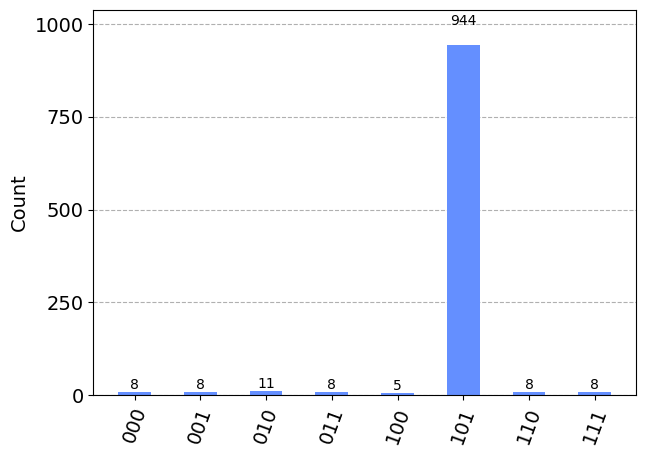

In [16]:
def input_state(circuit, f_in, f_out, n):
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
n = 3

exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

ans = ClassicalRegister(n)

grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

input_state(grover, f_in, f_out, n)
T = 2
for t in range(T):
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)

for j in range(n):
    grover.measure(f_in[j], ans[j])

backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=1000)
result = job.result()

counts = result.get_counts(grover)
plot_histogram(counts)